<a href="https://colab.research.google.com/github/adnan-kibria/cvpr_assignment/blob/main/MID/assignment_2_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
path = '/content/drive/MyDrive/Dataset/random_dataset/random_dataset.csv'
df = pd.read_csv(path)
print(df.head())

   feature_1  feature_2  feature_3  feature_4  class
0   1.611326   5.042269   3.633166  -2.673706      1
1   5.546934   1.643341  -4.627222  -2.796811      4
2   3.252296   5.100132  -1.982558  -3.270648      3
3   2.955725   3.848868   4.737395  -2.433979      1
4  -4.268004   2.344520  -1.539793   1.221274      2


In [16]:
X = df[['feature_1', 'feature_2', 'feature_3', 'feature_4']].values
YRaw = df[['class']].values.flatten()
YRaw = YRaw - 1
Y = np.eye(5)[YRaw]

In [17]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 4
        hiddenLayer1Neurons = 32
        hiddenLayer2Neurons = 16
        hiddenLayer3Neurons = 8
        outputLayerNeurons = 5
        self.learningRate = 0.001
        self.W_HI1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons) * 0.01
        self.BI1 = np.zeros((1, hiddenLayer1Neurons))
        self.W_HI2 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons) * 0.01
        self.BI2 = np.zeros((1, hiddenLayer2Neurons))
        self.W_HI3 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons) * 0.01
        self.BI3 = np.zeros((1, hiddenLayer3Neurons))
        self.W_OH = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons) * 0.01
        self.BI4 = np.zeros((1, outputLayerNeurons))

    def ReLU(sef, x, der = False):
        if der == True:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    def Softmax(self, x):
        exp = np.exp(x - np.max(x, axis = 1, keepdims = True))
        return exp / np.sum(exp, axis = 1, keepdims = True)

    def forwardPropagation(self, X):
        hiddenInput1 = np.dot(X, self.W_HI1) + self.BI1
        self.hiddenOutput1 = self.ReLU(hiddenInput1)
        hiddenInput2 = np.dot(self.hiddenOutput1, self.W_HI2) + self.BI2
        self.hiddenOutput2 = self.ReLU(hiddenInput2)
        hiddenInput3 = np.dot(self.hiddenOutput2, self.W_HI3) + self.BI3
        self.hiddenOutput3 = self.ReLU(hiddenInput3)
        outputInput = np.dot(self.hiddenOutput3, self.W_OH) + self.BI4
        prediction = self.Softmax(outputInput)

        return prediction

    def backPropagation(self, X, Y, prediction):
        outputDelta = (prediction - Y)
        gW_OH = np.dot(self.hiddenOutput3.T, outputDelta)
        gBI4 = np.sum(outputDelta, axis = 0, keepdims = True)
        hiddenOutput3Loss = np.dot(outputDelta, self.W_OH.T)
        hiddenOutput3Delta = hiddenOutput3Loss * self.ReLU(self.hiddenOutput3, der = True)
        gW_HI3 = np.dot(self.hiddenOutput2.T, hiddenOutput3Delta)
        gBI3 = np.sum(hiddenOutput3Delta, axis = 0, keepdims = True)
        hiddenOutput2Loss = np.dot(hiddenOutput3Delta, self.W_HI3.T)
        hiddenOutput2Delta = hiddenOutput2Loss * self.ReLU(self.hiddenOutput2, der = True)
        gW_HI2 = np.dot(self.hiddenOutput1.T, hiddenOutput2Delta)
        gBI2 = np.sum(hiddenOutput2Delta, axis = 0, keepdims = True)
        hiddenOutput1Loss = np.dot(hiddenOutput2Delta, self.W_HI2.T)
        hiddenOutput1Delta = hiddenOutput1Loss * self.ReLU(self.hiddenOutput1, der = True)
        gW_HI1 = np.dot(X.T, hiddenOutput1Delta)
        gBI1 = np.sum(hiddenOutput1Delta, axis = 0, keepdims = True)

        self.W_OH -= self.learningRate * gW_OH
        self.BI4 -= self.learningRate * gBI4
        self.W_HI3 -= self.learningRate * gW_HI3
        self.BI3 -= self.learningRate * gBI3
        self.W_HI2 -= self.learningRate * gW_HI2
        self.BI2 -= self.learningRate * gBI2
        self.W_HI1 -= self.learningRate + gW_HI1
        self.BI1 -= self.learningRate * gBI1

    def trainNeuralNetwork(self, X, Y):
        Z = self.forwardPropagation(X)
        self.backPropagation(X, Y, Z)

In [18]:
def splitTrainTestDataset(X, Y, testDatasetRatio):
    nSamples = X.shape[0]
    indices = np.arange(nSamples)
    np.random.shuffle(indices)
    testDatasetSize = int(nSamples * testDatasetRatio)
    testIndex = indices[:testDatasetSize]
    trainIndex = indices[testDatasetSize:]
    return X[trainIndex], X[testIndex], Y[trainIndex], Y[testIndex]

xTrain, xTest, yTrain, yTest = splitTrainTestDataset(X, Y, 0.2)

In [19]:
NN = NeuralNetwork()

maxEpochs = 3000
minEpochs = 60
bestLoss = float('inf')
epochCounter = 0

for epoch in range(maxEpochs):

    NN.trainNeuralNetwork(xTrain, yTrain)
    predictionTrain = NN.forwardPropagation(xTrain)
    trainLoss = -np.mean(np.sum(yTrain * np.log(predictionTrain + 1e-9), axis=1))
    predictionTest = NN.forwardPropagation(xTest)
    testLoss = -np.mean(np.sum(yTest * np.log(predictionTest + 1e-9), axis=1))

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Train Loss={trainLoss:.4f} | Test Loss={testLoss:.4f}")

    if testLoss < bestLoss:
        bestLoss = testLoss
        epochCounter = 0
        bestWeights = {
            'W_HI1': NN.W_HI1.copy(),
            'BI1': NN.BI1.copy(),
            'W_HI2': NN.W_HI2.copy(),
            'BI2': NN.BI2.copy(),
            'W_HI3': NN.W_HI3.copy(),
            'BI3': NN.BI3.copy(),
            'W_OH': NN.W_OH.copy(),
            'BI4': NN.BI4.copy(),
        }
    else:
        epochCounter += 1

    if epochCounter >= minEpochs:
        print("\nEarly stopping triggered!")
        break

for k, v in bestWeights.items():
    setattr(NN, k, v)


Epoch 0 | Train Loss=1.6093 | Test Loss=1.6101
Epoch 20 | Train Loss=1.6084 | Test Loss=1.6173
Epoch 40 | Train Loss=1.6082 | Test Loss=1.6185
Epoch 60 | Train Loss=1.5780 | Test Loss=1.5849
Epoch 80 | Train Loss=1.1833 | Test Loss=1.1566
Epoch 100 | Train Loss=1.1560 | Test Loss=1.1305
Epoch 120 | Train Loss=1.1458 | Test Loss=1.1307
Epoch 140 | Train Loss=1.1149 | Test Loss=1.0880
Epoch 160 | Train Loss=1.0183 | Test Loss=1.0211
Epoch 180 | Train Loss=0.7836 | Test Loss=0.7425
Epoch 200 | Train Loss=0.6874 | Test Loss=0.6488
Epoch 220 | Train Loss=0.6800 | Test Loss=0.6379
Epoch 240 | Train Loss=0.4924 | Test Loss=0.4348
Epoch 260 | Train Loss=0.3980 | Test Loss=0.3163
Epoch 280 | Train Loss=0.3709 | Test Loss=0.2886
Epoch 300 | Train Loss=2.3526 | Test Loss=2.2982
Epoch 320 | Train Loss=1.3268 | Test Loss=1.3328
Epoch 340 | Train Loss=1.3263 | Test Loss=1.3335

Early stopping triggered!


In [20]:
yPredictionProbability = NN.forwardPropagation(xTest)
yPrediction = np.argmax(yPredictionProbability, axis = 1)
yTrueIndex = np.argmax(yTest, axis = 1)

In [21]:
def accuracy(yTrueIndex, yPrediction):
    accurate = (yTrueIndex == yPrediction)
    accuracy = np.mean(accurate)
    return accuracy

accuracy = accuracy(yTrueIndex, yPrediction)
print('Accuracy: ', accuracy)

Accuracy:  0.8


Confusion Matrix:
 [[ 0  0  0  0 20]
 [ 0 22  0  0  0]
 [ 0  0 24  0  0]
 [ 0  0  0 21  0]
 [ 0  0  0  0 13]]


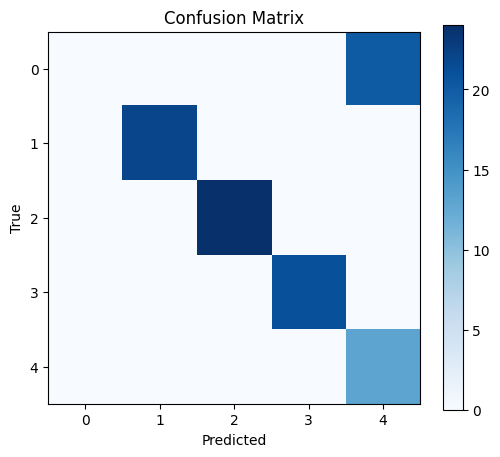

In [22]:
def confusionMatrix(yTrueIndex, yPrediction, nClass):
    confusionMatrix = np.zeros((nClass, nClass), dtype = int)
    for true, prediction in zip(yTrueIndex, yPrediction):
        confusionMatrix[true][prediction] += 1
    return confusionMatrix

confusionMatrix = confusionMatrix(yTrueIndex, yPrediction, 5)
print("Confusion Matrix:\n", confusionMatrix)

plt.figure(figsize=(6,5))
plt.imshow(confusionMatrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

In [23]:
def precisionRecallF1(confusionMatrix):
    nClasses = confusionMatrix.shape[0]
    precision = np.zeros(nClasses)
    recall = np.zeros(nClasses)
    f1 = np.zeros(nClasses)
    for c in range(nClasses):
        truePositive = confusionMatrix[c][c]
        falsePositive = confusionMatrix[:,c].sum() - truePositive
        falseNegative = confusionMatrix[c,:].sum() - truePositive
        precision[c] = truePositive / (truePositive + falsePositive + 1e-9)
        recall[c] = truePositive / (truePositive + falseNegative + 1e-9)
        f1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c] + 1e-9)
    return precision, recall, f1

precision, recall, f1 = precisionRecallF1(confusionMatrix)

In [24]:
for c in range(5):
    print(f'Class {c}: ')
    print('Precision: ', precision[c])
    print(' Recall: ', recall[c])
    print(' F1: ', f1[c])
    print()

print('Total Accuracy: ', accuracy)

Class 0: 
Precision:  0.0
 Recall:  0.0
 F1:  0.0

Class 1: 
Precision:  0.9999999999545455
 Recall:  0.9999999999545455
 F1:  0.9999999994545454

Class 2: 
Precision:  0.9999999999583333
 Recall:  0.9999999999583333
 F1:  0.9999999994583333

Class 3: 
Precision:  0.999999999952381
 Recall:  0.999999999952381
 F1:  0.9999999994523809

Class 4: 
Precision:  0.3939393939274564
 Recall:  0.9999999999230769
 F1:  0.5652173908742911

Total Accuracy:  0.8
